# Library

In [1]:
# My library
from molgraph.dataset import *
from molgraph.testingconsensus import *
from molgraph.visualize import *
from molgraph.interpret import *
from molgraph.experiment import *
# General library
import numpy as np
import pandas as pd
import scipy as sp
import os
# pytorch
import torch
from matplotlib.pyplot import figure

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_theme(style="white", palette=None)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


# Argument

In [2]:
parser = ArgumentParser()
args = parser.getArgument('''
--file bbbp
--model GIN
--schema AR_0
--reduced functional
--mol_embedding 256
--batch_normalize
--fold 5
'''.split())

args

Namespace(batch_normalize=True, batch_size=256, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='t04_CYP2C8_533', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=3, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=3, out_channels=256, patience=30, reduced=['functional'], schema='AR_0', seed=42, smiles='smiles', splitting='split', splitting_seed=42, task='class', vocab_len=100, weight_decay=5e-05)

# Dataset

In [3]:
file = args.file
smiles = args.smiles 
task = args.task
splitting = args.splitting 
splitting_fold = args.fold
splitting_seed = args.splitting_seed

# get validated dataset
datasets = getDataset(file, smiles, task, splitting)
# compute positive weight for classification
if args.graphtask == 'classification':
    args.pos_weight = getPosWeight(datasets)
    print('pos_weight:', args.pos_weight)
# generate dataset splitting
datasets_splitted = generateDatasetSplitting(file, splitting, splitting_fold, splitting_seed)
# generate all graph dataset
datasets_graph = generateGraphDataset(file)
# generate all reduced graph dataset
dict_reducedgraph = dict()
for g in args.reduced:
    if g == 'substructure':
        for i in range(splitting_fold):
            vocab_file = file+'_'+str(i)
            if not os.path.exists('vocab/'+vocab_file+'.txt'):
                generateVocabTrain(file, splitting_seed, splitting_fold, vocab_len=args.vocab_len)
            dict_reducedgraph[g] = generateReducedGraphDict(file, g, vocab_file=vocab_file)
    else:
        dict_reducedgraph[g] = generateReducedGraphDict(file, g)

Function: getDataset()
number of valid smiles: 533
pos_weight: 0.7083333333333334
Function: generateDatasetSplitting()
Fold: 5
Fold Number: 0
-- Datasets Train: 354
-- Datasets Val: 88
-- Datasets Test:  91
-- Total: 533
Fold Number: 1
-- Datasets Train: 354
-- Datasets Val: 88
-- Datasets Test:  91
-- Total: 533
Fold Number: 2
-- Datasets Train: 354
-- Datasets Val: 88
-- Datasets Test:  91
-- Total: 533
Fold Number: 3
-- Datasets Train: 353
-- Datasets Val: 89
-- Datasets Test:  91
-- Total: 533
Fold Number: 4
-- Datasets Train: 353
-- Datasets Val: 89
-- Datasets Test:  91
-- Total: 533
Function: generateGraphDataset()
Datasets graph:  531


# Test

In [4]:
import os
args_test = dict()

# Load model
ts = "2023-Apr-09-15:27:48"
args_test = dict()
reduced_list = '_'.join(args.reduced)
# directory = './dataset/'+os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list])
# ts = next(os.walk(directory))[1][0]
reduced_list = '_'.join(args.reduced)
args_test['log_folder_name'] = os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list, f"{ts}"])
args_test['exp_name'] = args.experiment_number
# args_test['fold_number'] = fold_number
args_test['seed'] = args.seed

training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

args.batch_size = training_bin.batch_size
args.num_layers = training_bin.num_layers
args.num_layers_reduced = training_bin.num_layers_reduced
args.in_channels = training_bin.in_channels
args.hidden_channels = training_bin.hidden_channels
args.out_channels = training_bin.out_channels
args.edge_dim = training_bin.edge_dim
args.num_layers_self = training_bin.num_layers_self
args.num_layers_self_reduced = training_bin.num_layers_self_reduced
args.dropout = training_bin.dropout
args.lr = training_bin.lr
args.weight_decay = training_bin.weight_decay
# print(args)
testing_smiles = ''

# # test with single sample
# testing_type = 'sample'
# testing_smiles = 'O=C1NC(=O)SC1Cc4ccc(OCC3(Oc2c(c(c(O)c(c2CC3)C)C)C)C)cc4'
# smiles_processes = mol_to_smiles(smiles_to_mol(testing_smiles, with_atom_index=False))
# molecule_test = constructGraph(smiles_processes, 0)
# datasets_test = {testing_smiles: molecule_test}

# # test dataset original
# testing_type = 'test_dataset'
# test_loader, datasets_test =  generateDataLoaderTesting(args.file, args.batch_size)

# # test dataset external
# testing_type = 'external'
# test_external = 'test_external.csv'
# datasets_test_df = pd.read_csv('dataset/'+args.file+'/'+test_external)
# datasets_test_list = []
# for idx, row in datasets_test_df.iterrows():
#     smiles_processes = mol_to_smiles(smiles_to_mol(row['X'], with_atom_index=False))
#     d = constructGraph(smiles_processes, row['y'])
#     datasets_test_list.append(d)
# test_loader, datasets_test =  generateDataLoaderListing(datasets_test_list, 1)
# datasets_test = {d.smiles: d for d in datasets_test}

# all dataset
testing_type = 'dataset'
datasets_test = datasets_graph


all_dataset = datasets_test

# Running

In [6]:
print('Number of dataset:', len(all_dataset))

Number of dataset: 531


In [7]:
if testing_type == 'sample' or testing_type == 'external' or testing_type == 'test_dataset':
    prediction_fold_df = getSubstructureFold(args, args_test, all_dataset, datasets_splitted=None)
    # prediction_consensus_df = getSubstructureConsensus(prediction_fold_df)
    
elif testing_type == 'dataset':
    reduced_list = '_'.join(args.reduced)
    directory = args.model+'_'+args.schema+'_'+reduced_list
    path_fold = 'dataset/'+file+'/substructure_fold_'+args.file+'_'+directory+'.csv'
    path_consensus = 'dataset/'+file+'/substructure_consensus_'+args.file+'_'+directory+'.csv'
    prediction_fold_df = pd.DataFrame()
    prediction_consensus_df = pd.DataFrame()

    if os.path.exists(path_fold):
        prediction_fold_df = pd.read_csv(path_fold)
    else:
        prediction_fold_df = getSubstructureFold(args, args_test, all_dataset, datasets_splitted=datasets_splitted)
        prediction_fold_df.to_csv(path_fold, index=False)

    # if os.path.exists(path_consensus):
    #     prediction_consensus_df = pd.read_csv(path_consensus)
    # else:
    #     prediction_consensus_df = getSubstructureConsensus(prediction_fold_df)
    #     prediction_consensus_df.to_csv(path_consensus, index=False)

print('prediction_fold_df', len(prediction_fold_df))
# print('prediction_consensus_df', len(prediction_consensus_df))

getMaskGraph: 100%|██████████| 531/531 [02:41<00:00,  3.30it/s]


prediction_fold_df 48900


In [8]:
prediction_fold_df.head()

,Fold,SMILES_original,SMILES,Split,Prediction,TrueValue,Schema,Node_ID,Node_Feature,Weight_Sub,Weight_Other
0,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~OC(~*)=O,"[0.3460856023124791, 0.42905664304650143, 0.84...","[0.43172264664962506, 1.0, 0.6728470259733668,..."
1,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~OCC,"[0.43172264664962506, 0.3460856023124791, 0.42...","[0.25675838028672393, 0.5852450231825244, 1.0,..."
2,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~C1CCN(C(=O)OCC)CC1,"[0.43172264664962506, 0.3460856023124791, 0.42...","[0.9576450749008525, 0.2857846483050174, 0.285..."
3,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~C1CCN(C(~*)=O)CC1,"[0.42905664304650143, 0.8437477383550895, 0.25...","[0.43172264664962506, 0.3460856023124791, 0.95..."
4,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~OC(=O)N1CCC(~*)CC1,"[0.3460856023124791, 0.42905664304650143, 0.84...","[0.43172264664962506, 0.9576450749008525, 0.28..."


In [9]:
# prediction_consensus_df.head()

In [10]:
# if testing_type == 'sample':
#     smiles_test = Chem.MolToSmiles(Chem.MolFromSmiles(testing_smiles))
# else:
#     smiles_test = Chem.MolToSmiles(Chem.MolFromSmiles(list(all_dataset.keys())[0]))
    
# prediction_mol_df = prediction_consensus_df[prediction_consensus_df['SMILES_original'] == smiles_test]
# prediction_mol_df
# getPrediction(prediction_mol_df, args, print_result=True)

In [20]:
prediction_fold_df['Weight_Sub_Avg'] = prediction_fold_df['Weight'].apply(lambda x: np.mean(x).astype(float))
prediction_fold_df.head()

,Fold,SMILES_original,SMILES,Split,Prediction,TrueValue,Schema,Node_ID,Node_Feature,Weight_Sub,Weight_Other,Weight_Sub_Avg
0,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~OC(~*)=O,"[0.3460856023124791, 0.42905664304650143, 0.84...","[0.43172264664962506, 1.0, 0.6728470259733668,...",0.492179
1,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~OCC,"[0.43172264664962506, 0.3460856023124791, 0.42...","[0.25675838028672393, 0.5852450231825244, 1.0,...",0.512653
2,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~C1CCN(C(=O)OCC)CC1,"[0.43172264664962506, 0.3460856023124791, 0.42...","[0.9576450749008525, 0.2857846483050174, 0.285...",0.649829
3,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~C1CCN(C(~*)=O)CC1,"[0.42905664304650143, 0.8437477383550895, 0.25...","[0.43172264664962506, 0.3460856023124791, 0.95...",0.702014
4,0.0,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,C[CH2:1][O:2][C:3](=[O:4])[N:5]1[CH2:6][CH2:7]...,train,0.168367,1.0,x,26.0,*~OC(=O)N1CCC(~*)CC1,"[0.3460856023124791, 0.42905664304650143, 0.84...","[0.43172264664962506, 0.9576450749008525, 0.28...",0.669657


In [22]:
groupby_column = ['SMILES_original', 'SMILES', 'Split', 'Schema', 'Node_ID', 'Node_Feature']
selected_column = ['Prediction', 'TrueValue', 'Weight_Sub_Avg']
prediction_fold_df = prediction_fold_df[[*groupby_column, *selected_column]]
prediction_consensus_df = prediction_fold_df.groupby(groupby_column).mean()[selected_column]
prediction_consensus_df.reset_index(inplace=True)
prediction_consensus_df['Fold'] = 'C'
prediction_consensus_df = prediction_consensus_df[prediction_fold_df.columns]
prediction_consensus_df.head()

,SMILES_original,SMILES,Split,Schema,Node_ID,Node_Feature,Prediction,TrueValue,Weight_Sub_Avg
0,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,C#[C:1][c:2]1[cH:3][cH:4][cH:5][c:6]([NH:7][c:...,train,x,28.0,*~CCOC,0.864359,1.0,0.466554
1,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,C#[C:1][c:2]1[cH:3][cH:4][cH:5][c:6]([NH:7][c:...,train,x,28.0,*~CCOc1cc2c(N~*)ncnc2cc1OCCOC,0.864359,1.0,0.448350
2,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,C#[C:1][c:2]1[cH:3][cH:4][cH:5][c:6]([NH:7][c:...,train,x,28.0,*~CCOc1cc2c(N~*)ncnc2cc1O~*,0.864359,1.0,0.445947
3,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,C#[C:1][c:2]1[cH:3][cH:4][cH:5][c:6]([NH:7][c:...,train,x,28.0,*~CCOc1cc2c(N~*)ncnc2cc1~*,0.864359,1.0,0.447774
4,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,C#[C:1][c:2]1[cH:3][cH:4][cH:5][c:6]([NH:7][c:...,train,x,28.0,*~CCOc1cc2c(~*)ncnc2cc1OCCOC,0.864359,1.0,0.439234


In [40]:
np.mean(prediction_consensus_df['Weight_Sub_Avg'])

0.4459168727884029

# IG

,Node_Feature,Node_Feature_nodes_series,Node_Feature_smiles_series
0,*~c1ccccc1,87,87
1,*~NC(~*)=O,84,84
2,*~c1ccc(~*)cc1,71,71
3,*~C(O)=O,47,47
4,*~Oc1ccc(~*)cc1,31,31
...,...,...,...
5080,*~Cn1nc(~*)cc1-c1ccc(OC(F)(F)F)cc1,1,1
5081,*~Cn1nc(~*)cc1-c1ccc(~*)cc1,1,1
5082,*~Cn1nc(~*)cc1~*,1,1
5083,*~c1ccnc(C#N)c1,1,1


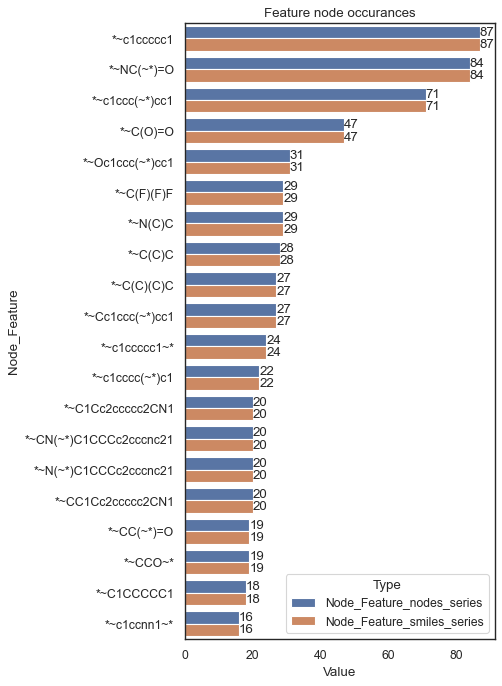

In [25]:
pred_ar_df = prediction_consensus_df

def countOccurance(pred_df):
    # all nodes
    feature_occ_nodes_series = pred_df['Node_Feature'].value_counts()
    # unique smiles
    pred_ar_df_unique = pred_df.drop_duplicates(subset=['SMILES', 'Node_Feature'])
    feature_occ_smiles_series = pred_ar_df_unique['Node_Feature'].value_counts()
    # concat
    feature_occ_df = pd.DataFrame(feature_occ_nodes_series)
    feature_occ_df = feature_occ_df.merge(feature_occ_smiles_series, how='outer', left_index=True, right_index=True, suffixes=('_nodes_series', '_smiles_series'))
    feature_occ_df = feature_occ_df.sort_values(by=['Node_Feature_nodes_series'], ascending=False)
    feature_occ_df = feature_occ_df.reset_index().rename(columns={'index':'Node_Feature'})
    return feature_occ_df

feature_occ_df = countOccurance(pred_ar_df)
display(feature_occ_df)

# plot
feature_occ_df_melt = pd.melt(feature_occ_df.head(20), id_vars='Node_Feature', value_vars=['Node_Feature_nodes_series', 'Node_Feature_smiles_series'], var_name='Type', value_name='Value')
figure(figsize=(5, len(feature_occ_df_melt)//4), dpi=80)
fig = sns.barplot(data=feature_occ_df_melt, x='Value', y='Node_Feature', hue='Type')
fig.set_title('Feature node occurances')

for i in fig.containers:
    fig.bar_label(i,)

In [59]:
feature_mt_10 = feature_occ_df[(feature_occ_df['Node_Feature_nodes_series']>=10) & (feature_occ_df['Node_Feature_smiles_series']>=10)]['Node_Feature'].tolist()
len(feature_mt_10)

76

In [64]:
# calculate the information gain
from math import log2

# calculate the entropy for the split in the dataset
def entropy(class0, class1):
    if class0 == 0 and class1 != 0:
        return -(class1 * log2(class1))
    elif class1 == 0 and class0 != 0:
        return -(class0 * log2(class0))
    return -(class0 * log2(class0) + class1 * log2(class1))

if args.graphtask == 'classification':
    threshold_prediction = 0.5
    threshold_weight = 0.5
    
    pred_ar_df = prediction_consensus_df
    # filter by list
    pred_ar_df = pred_ar_df[pred_ar_df['Node_Feature'].isin(feature_mt_10)]

    avg_att_df = pred_ar_df.groupby(['Node_Feature'])['Weight_Sub_Avg'].mean().reset_index().sort_values(by=['Weight_Sub_Avg'], ascending=False).reset_index(drop=True)
    labels = list(avg_att_df['Node_Feature'])
    pred_ar_df = pred_ar_df.sort_values(by='Node_Feature', key=lambda x: x.map({v: i for i, v in enumerate(avg_att_df['Node_Feature'])}))
    
    ig_list = list()
    for l in labels:
        # Information Gain (IG)
        # split of the main dataset
        class_pred = pred_ar_df[pred_ar_df['Node_Feature']==l]
        class0 = len(class_pred[class_pred['Prediction']<threshold_prediction]) / len(class_pred)
        class1 = len(class_pred[class_pred['Prediction']>=threshold_prediction]) / len(class_pred)
        # calculate entropy before the change
        s_entropy = entropy(class0, class1)
        # print('Dataset Entropy: %.3f bits' % s_entropy)
        
        # split 1 (split via value1)
        s1 = class_pred[class_pred['Prediction']<threshold_prediction]
        if len(s1) == 0:
            s1_entropy = 0
        else:
            s1_class0 = len(s1[s1['Weight_Sub_Avg']<threshold_weight]) / len(s1)
            s1_class1 = len(s1[s1['Weight_Sub_Avg']>=threshold_weight]) / len(s1)
            # calculate the entropy of the first group
            s1_entropy = entropy(s1_class0, s1_class1)
        # print('Group1 Entropy: %.3f bits' % s1_entropy)
        
        # split 2  (split via value2)
        s2 = class_pred[class_pred['Prediction']>=threshold_prediction]
        if len(s2) == 0:
            s2_entropy = 0
        else:
            s2_class0 = len(s2[s2['Weight_Sub_Avg']<threshold_weight]) / len(s2)
            s2_class1 = len(s2[s2['Weight_Sub_Avg']>=threshold_weight]) / len(s2)
            # calculate the entropy of the second group
            s2_entropy = entropy(s2_class0, s2_class1)
        # print('Group2 Entropy: %.3f bits' % s2_entropy)
        
        # calculate the information gain
        # print('Check', len(class_pred), '=', len(s1), '+', len(s2))
        gain = s_entropy - (len(s1)/len(class_pred) * s1_entropy + len(s2)/len(class_pred) * s2_entropy)
        gain = -gain if class0 > class1 else gain
        # print('Information Gain: %.3f bits' % gain)
        # print('-------------------------------------------')
        ig_list.append(gain)

    avg_att_df['IG'] = ig_list
    avg_att_df = avg_att_df.sort_values(by=['IG'], ascending=True).reset_index(drop=True)
    display(len(avg_att_df), avg_att_df)

    # for f in avg_att_df.iterrows():
    #     print(f[1]['Node_Feature'], '\t', f[1]['Weight_Sub_Avg'], '\t', f[1]['IG'])

76

,Node_Feature,Weight_Sub_Avg,IG
0,*~c1ccc2nc(~*)[nH]c2c1,0.483240,-0.985228
1,*~Sc1nc2ccc(~*)cc2[nH]1,0.492567,-0.985228
2,*~Sc1nc2ccc(OC)cc2[nH]1,0.498663,-0.985228
3,*~CSc1nc2ccc(~*)cc2[nH]1,0.524539,-0.970951
4,*~C(=O)c1nc(~*)c(~*)s1,0.543221,-0.970951
...,...,...,...
71,*~C(C)C(~*)=O,0.529557,0.811278
72,*~c1ccccc1,0.269482,0.911663
73,*~C(=O)c1ccc(~*)cc1,0.349781,0.918296
74,*~c1ccc(F)cc1,0.366505,0.918296


In [65]:
ig_mt_0 = avg_att_df[avg_att_df['IG']>0]
ig_mt_0 = ig_mt_0.sort_values(by=['IG'], ascending=False).reset_index(drop=True)
print("IG > 0", len(ig_mt_0))
ig_lt_0 = avg_att_df[avg_att_df['IG']<0]
ig_lt_0 = ig_lt_0.sort_values(by=['IG'], ascending=True).reset_index(drop=True)
print("IG < 0", len(ig_lt_0))
ig_eq_0 = avg_att_df[avg_att_df['IG']==0]
print("IG = 0", len(ig_eq_0))

IG > 0 28
IG < 0 29
IG = 0 19


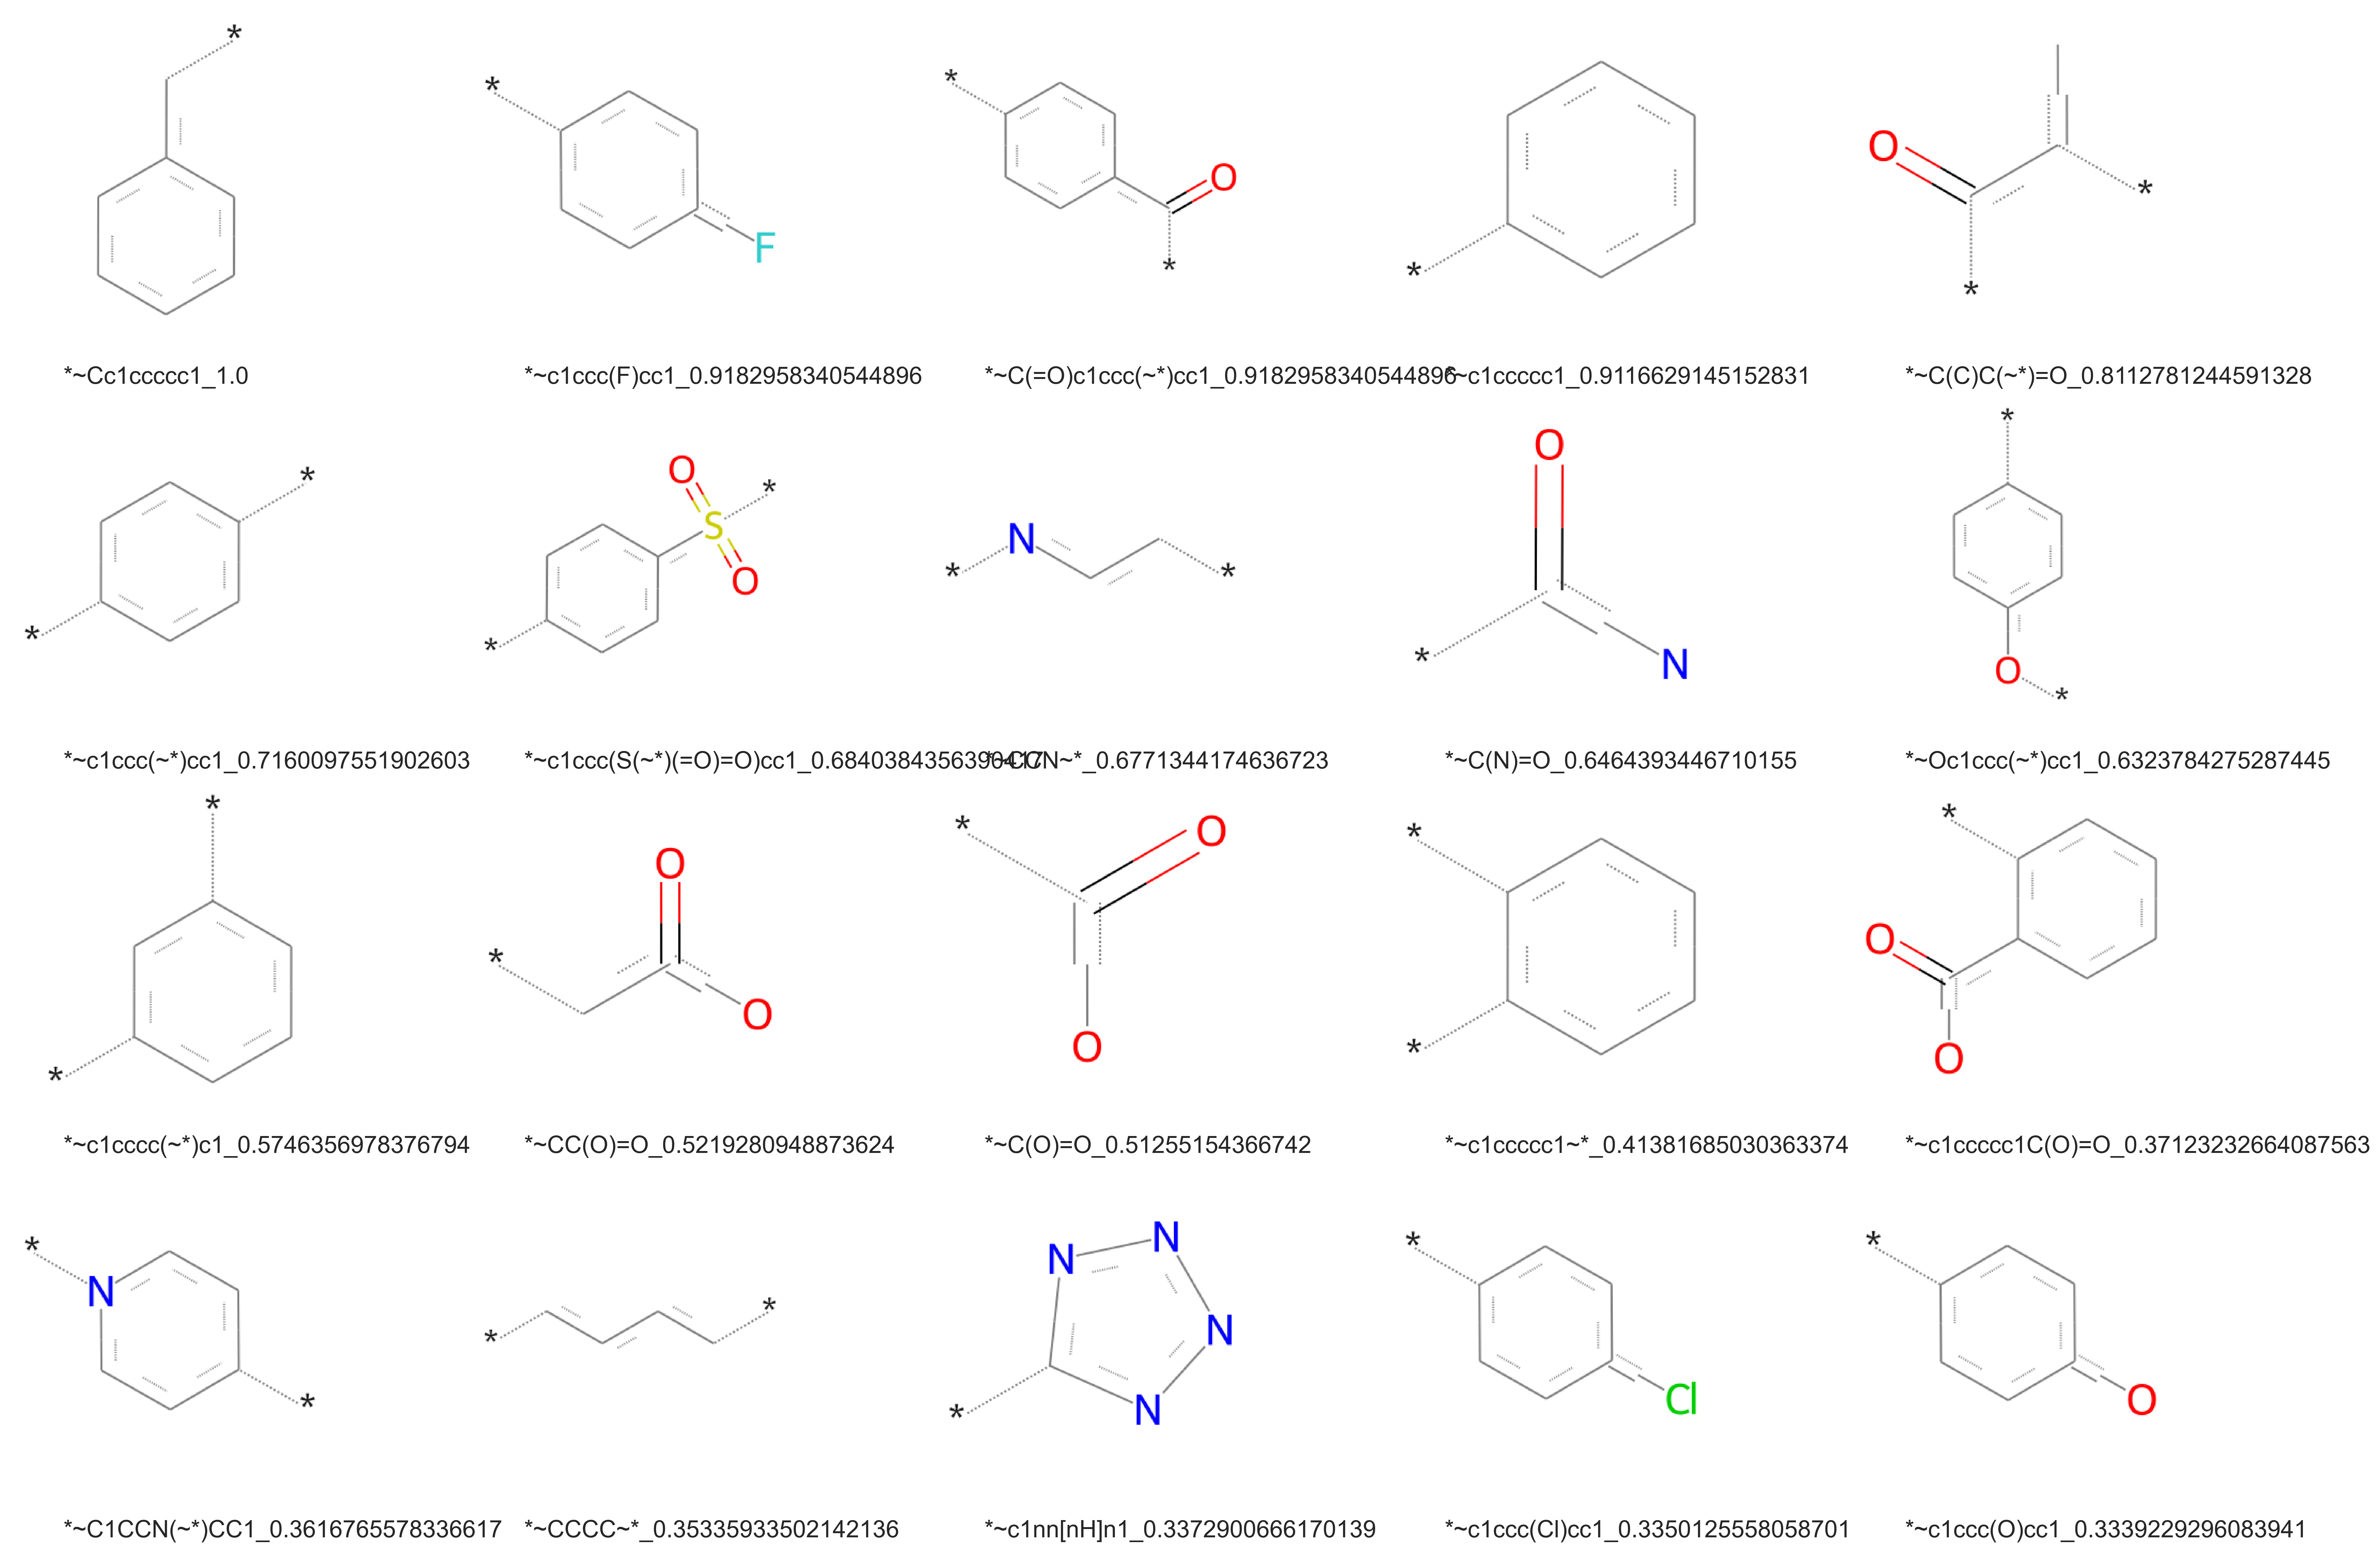

In [66]:
drawGridMolecule([Chem.MolFromSmarts(t['Node_Feature']) for i,t in ig_mt_0.head(20).iterrows()], 
                 labels=[t['Node_Feature']+'_'+str(t['IG']) for i,t in ig_mt_0.head(20).iterrows()])

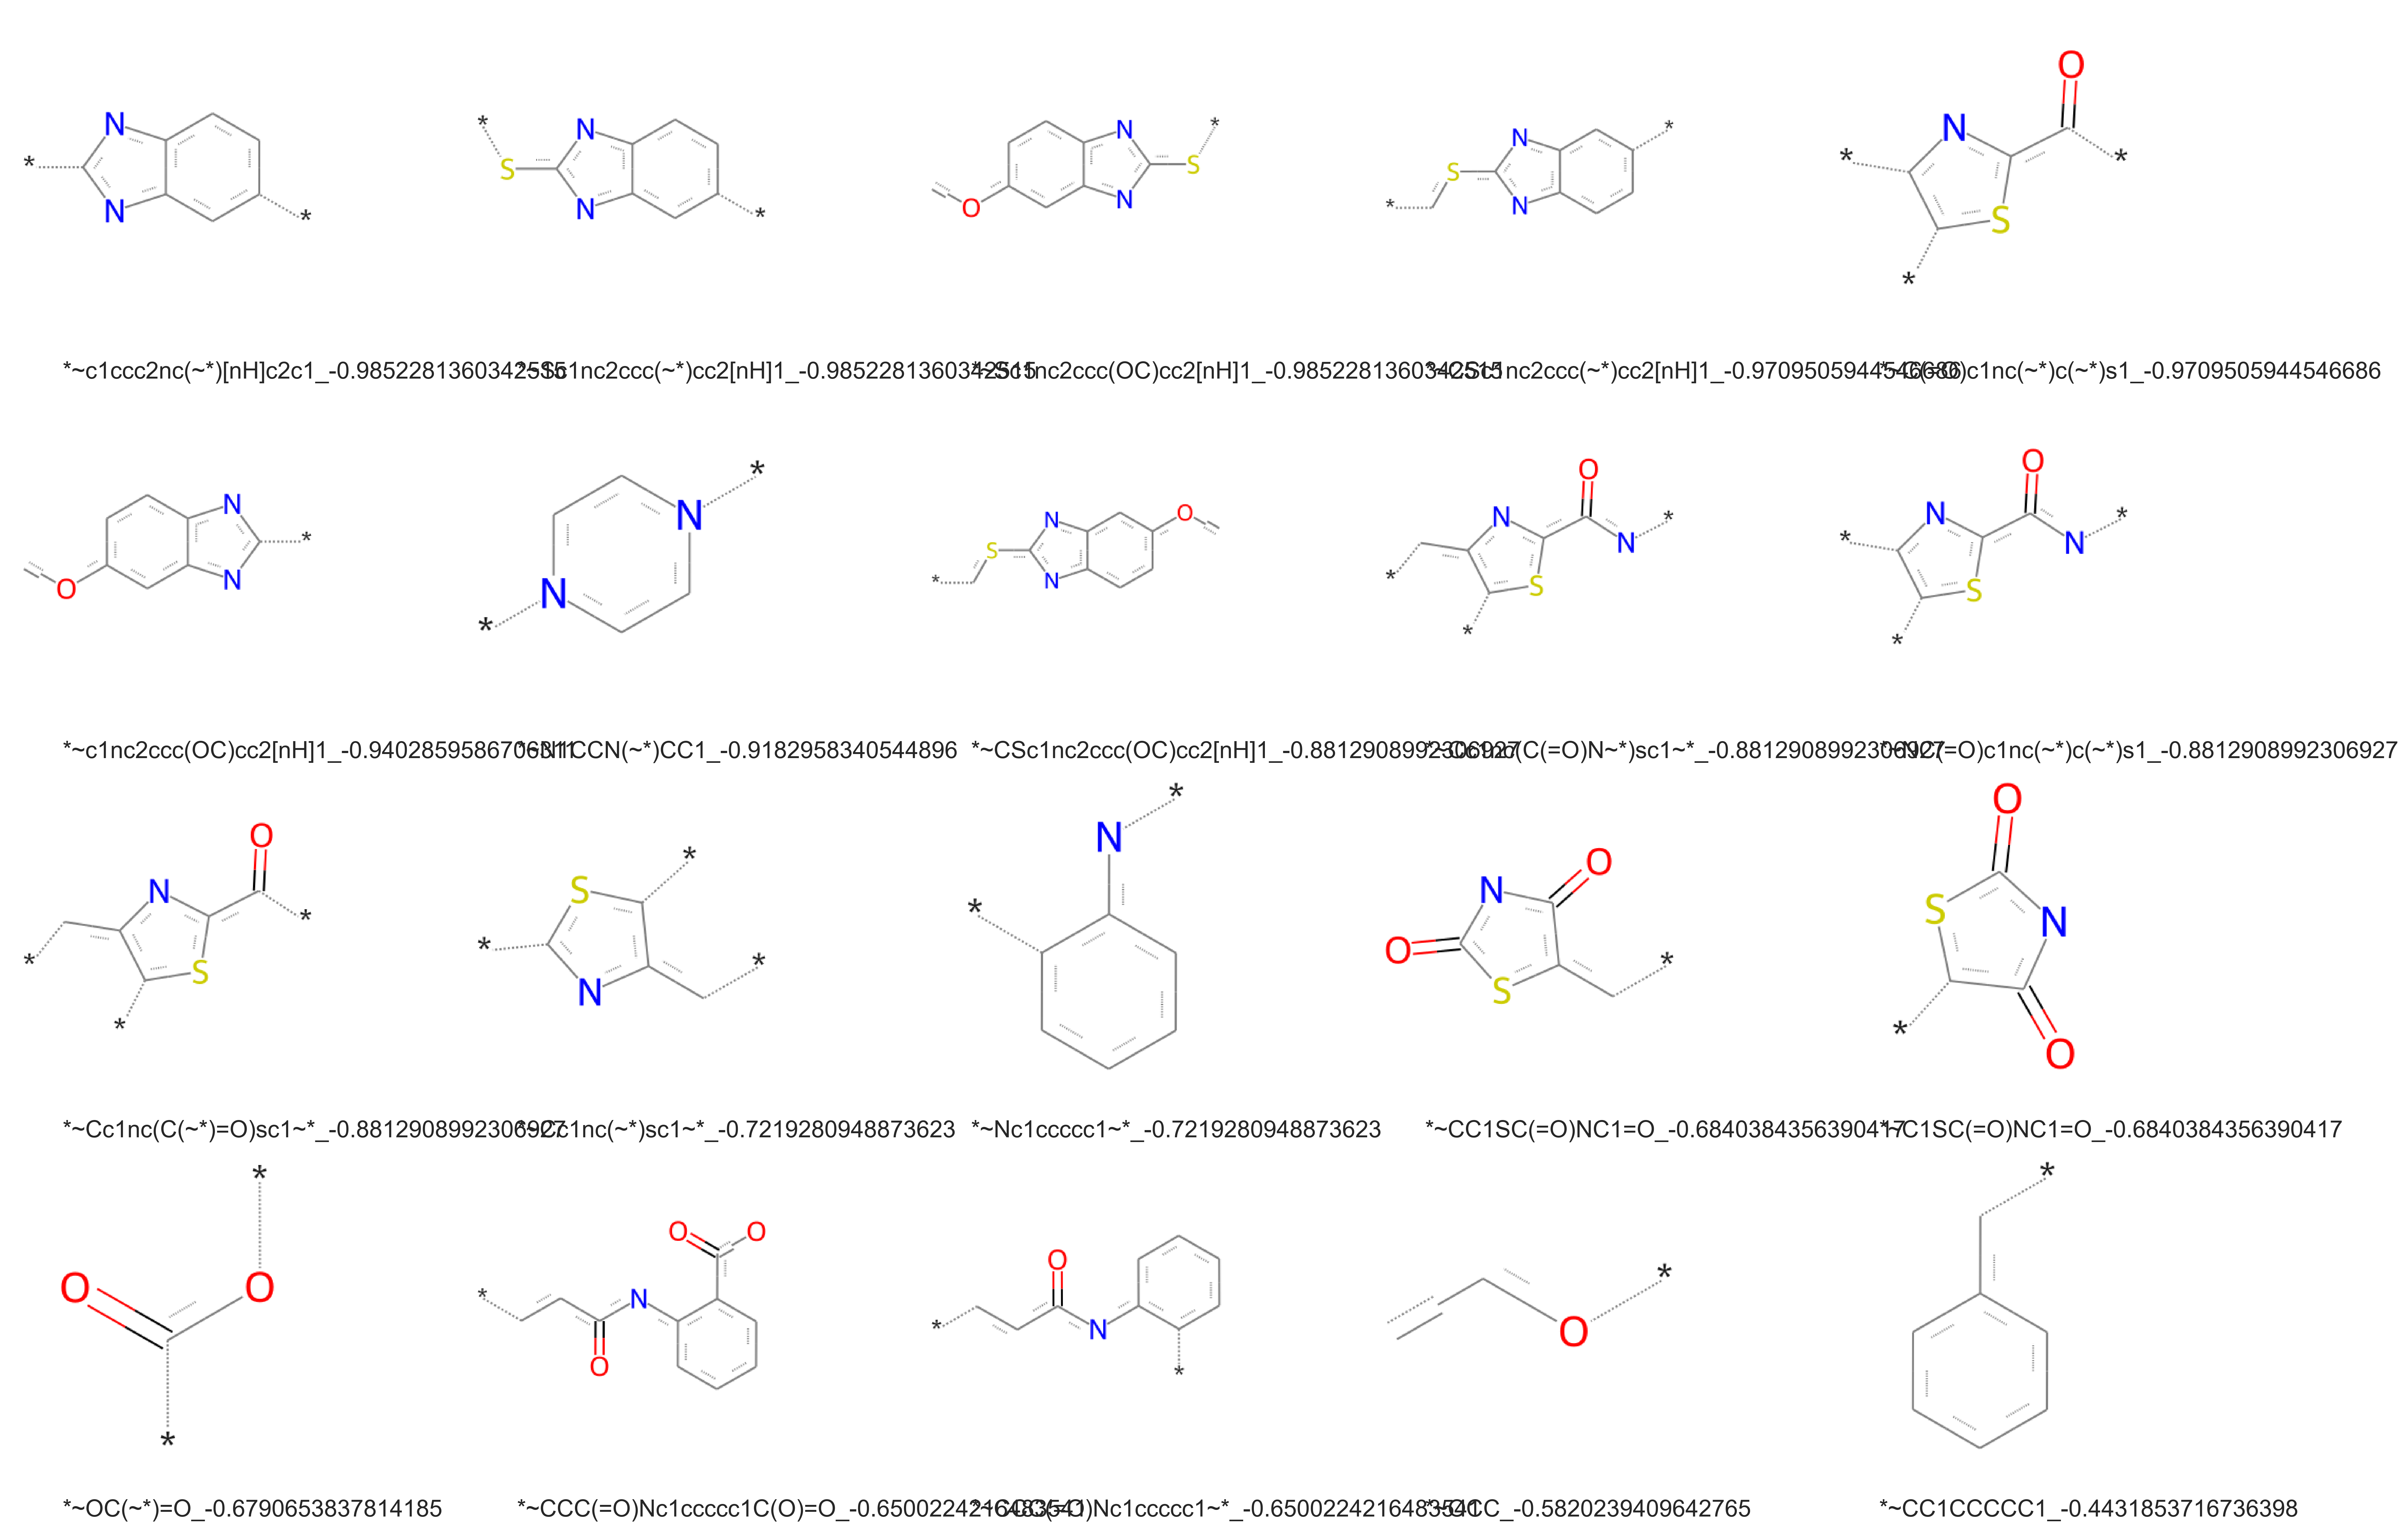

In [67]:
drawGridMolecule([Chem.MolFromSmarts(t['Node_Feature']) for i,t in ig_lt_0.head(20).iterrows()], 
                 labels=[t['Node_Feature']+'_'+str(t['IG']) for i,t in ig_lt_0.head(20).iterrows()])